In [46]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [47]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')


Unindo os dataframes

In [48]:
df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

In [49]:
print(df.columns)

Index(['order_id', 'store_id', 'channel_id', 'payment_order_id',
       'delivery_order_id', 'order_status', 'order_amount',
       'order_delivery_fee', 'order_delivery_cost', 'order_created_hour',
       'order_created_minute', 'order_created_day', 'order_created_month',
       'order_moment_created', 'order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'hub_id',
       'store_segment', 'store_plan_price', 'store_latitude',
       'store_longitude', 'hub_city', 'hub_latitude', 'hub_longitude',
       'channel_type', 'payment_id', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status', 'de

Agora com o dataframe todo unido, dropar colunas de id que não agregam no modelo

In [50]:
#função base que muda o dataframe

grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao(df):
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])

    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #duplicadas
    df = df.drop_duplicates()

    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    # Calcular a diferença entre as duas colunas em minutos
    df['order_metric'] = (df['order_moment_finished'] - df['order_moment_created']).dt.total_seconds() / 60

    # Exibir o DataFrame resultante
    print(df['order_metric'])

    df = df.loc[df['order_metric'] >= 0]

    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]



In [51]:
df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered'])

print(df.columns)

Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'channel_type', 'payment_amount',
       'payment_fee', 'payment_method', 'payment_status',
       'delivery_distance_meters', 'delivery_status', 'driver_modal',
       'driver_type'],
      dtype='object')


limpeza inciail dos dados

analise de cada coluna

In [52]:
print(df.columns)


Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'channel_type', 'payment_amount',
       'payment_fee', 'payment_method', 'payment_status',
       'delivery_distance_meters', 'delivery_status', 'driver_modal',
       'driver_type'],
      dtype='object')


In [53]:
#order_status
print(df['order_status'].value_counts())

df = df[~df['order_status'].isin(['CANCELED'])]

order_status
FINISHED    287457
CANCELED         2
Name: count, dtype: int64


In [54]:
#como todos valores são finished será retirada
df = df.drop(columns='order_status')

print(df['payment_method'].value_counts())


payment_method
ONLINE                      223698
VOUCHER                      34467
DEBIT                         8941
MEAL_BENEFIT                  5131
STORE_DIRECT_PAYMENT          4780
CREDIT                        3667
DEBIT_STORE                   1573
VOUCHER_STORE                 1241
PAYMENT_LINK                  1144
CREDIT_STORE                   951
MONEY                          856
INSTALLMENT_CREDIT_STORE       350
VOUCHER_DC                     249
BANK_TRANSFER_DC               236
VOUCHER_OL                     173
Name: count, dtype: int64


In [55]:
grupo_pagamento = {
    'DEBIT': 'CARD',
    'CREDIT': 'CARD',
    'DEBIT_STORE': 'CARD',
    'CREDIT_STORE': 'CARD',
    'INSTALLMENT_CREDIT_STORE': 'CARD',
    'MEAL_BENEFIT': 'OTHER',
    'STORE_DIRECT_PAYMENT': 'OTHER',
    'PAYMENT_LINK': 'OTHER',
    'MONEY': 'OTHER',
    'BANK_TRANSFER_DC': 'OTHER',
    'VOUCHER_DC': 'VOUCHER',
    'VOUCHER_OL': 'VOUCHER',
    'VOUCHER_STORE': 'VOUCHER'
}

# Substituindo os valores da coluna 'payment_method' de acordo com o mapeamento
df['payment_method'] = df['payment_method'].replace(grupo_pagamento)

# Contando os novos valores únicos após a substituição
print(df['payment_method'].value_counts())

payment_method
ONLINE     223698
VOUCHER     36130
CARD        15482
OTHER       12147
Name: count, dtype: int64


In [56]:
print(df['payment_status'].value_counts())

payment_status
PAID          287111
CHARGEBACK       333
AWAITING          13
Name: count, dtype: int64


In [57]:
#retirar CHARGEBACK e AWAITING e por fim retirar a coluna

df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]

# Verificando se as linhas foram removidas corretamente
df = df.drop(columns='payment_status')

print(df['delivery_status'].value_counts())

delivery_status
DELIVERED     286995
DELIVERING       116
Name: count, dtype: int64


In [58]:
#retirar DELIVERING e por fim retirar a coluna

df = df[~df['delivery_status'].isin(['DELIVERING'])]

# Verificando se as linhas foram removidas corretamente
df = df.drop(columns='delivery_status')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286995 entries, 0 to 287458
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   order_id                           286995 non-null  int64  
 1   order_amount                       286995 non-null  int64  
 2   order_delivery_fee                 286995 non-null  int64  
 3   order_delivery_cost                284359 non-null  float64
 4   order_created_hour                 286995 non-null  int64  
 5   order_created_minute               286995 non-null  int64  
 6   order_created_day                  286995 non-null  int64  
 7   order_created_month                286995 non-null  int64  
 8   order_moment_created               286995 non-null  object 
 9   order_moment_finished              286993 non-null  object 
 10  order_metric_collected_time        262313 non-null  float64
 11  order_metric_paused_time           247808 no

In [60]:
df = df.drop_duplicates()

In [61]:
#valores nulos
print(df.isnull().sum())

order_id                                 0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                   1597
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    2
order_metric_collected_time          23531
order_metric_paused_time             37661
order_metric_production_time          7481
order_metric_walking_time            41495
order_metric_expediton_speed_time     9371
order_metric_transit_time             2302
order_metric_cycle_time                166
store_segment                            0
store_plan_price                     61611
store_latitude                         734
store_longitude                        734
hub_city                                 0
hub_latitude                             0
hub_longitu

In [62]:
df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time'])

In [63]:
print(df.isnull().sum())

order_id                                 0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                   1576
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    0
order_metric_collected_time          22997
order_metric_paused_time             37127
order_metric_production_time          6963
order_metric_walking_time            40952
order_metric_expediton_speed_time     8847
order_metric_transit_time             2285
order_metric_cycle_time                164
store_segment                            0
store_plan_price                     61091
store_latitude                           0
store_longitude                          0
hub_city                                 0
hub_latitude                             0
hub_longitu

order_delivery_cost

tem 1600 valores vazios. como a coluna é de custo, colocar 0 nos NaN

store_plan_price

como alguma precos sao nulos, valores NaN equivalem ao preco de plano 0

In [64]:
df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

In [65]:
print(df['order_moment_created'])

0           4/9/2021 3:49:59 PM
1          1/29/2021 9:19:06 PM
2          2/18/2021 8:49:48 PM
3          1/9/2021 10:35:40 PM
4           1/3/2021 4:22:42 PM
                  ...          
287454    3/29/2021 10:38:13 PM
287455      3/1/2021 5:04:20 PM
287456      4/8/2021 4:46:18 PM
287457      4/7/2021 4:35:15 PM
287458    2/15/2021 12:05:27 AM
Name: order_moment_created, Length: 274219, dtype: object


In [66]:
# Converter as colunas de string para datetime
df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

# Calcular a diferença entre as duas colunas em minutos
df['order_metric'] = (df['order_moment_finished'] - df['order_moment_created']).dt.total_seconds() / 60

# Exibir o DataFrame resultante
print(df['order_metric'])

df = df.loc[df['order_metric'] >= 0]

C:\Users\matus\AppData\Local\Temp\ipykernel_20956\2009913860.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_20956\2009913860.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



0          37.400000
1          37.433333
2          58.316667
3          38.100000
4          44.850000
             ...    
287454     22.716667
287455    307.500000
287456    547.116667
287457    168.916667
287458     46.550000
Name: order_metric, Length: 274219, dtype: float64


In [67]:
print(df.isnull().sum())

order_id                                 0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                      0
order_created_hour                       0
order_created_minute                     0
order_created_day                        0
order_created_month                      0
order_moment_created                     0
order_moment_finished                    0
order_metric_collected_time          22974
order_metric_paused_time             37098
order_metric_production_time          6951
order_metric_walking_time            40921
order_metric_expediton_speed_time     8828
order_metric_transit_time             2165
order_metric_cycle_time                 44
store_segment                            0
store_plan_price                         0
store_latitude                           0
store_longitude                          0
hub_city                                 0
hub_latitude                             0
hub_longitu

valores duplicados

In [68]:
df = df.drop_duplicates()

valores inconsistentes

In [69]:
coluna = 'order_amount'

valores_negativos = df.loc[df[coluna] < 0, coluna]

# Imprimir os valores negativos
print(valores_negativos)

Series([], Name: order_amount, dtype: int64)


In [70]:
#valores que são impossíveis de serem negativos

df = df.loc[df['order_metric_transit_time'] >= 0]
df = df.loc[df['order_metric_walking_time'] >= 0]
df = df.loc[df['order_metric_paused_time'] >= 0]
df = df.loc[df['order_metric_collected_time'] >= 0]

outliers

as colunas que tem outliers tem quantidade consideravel e eu acho valido considerá-los, talvez no futuro retirar casos muito fora da curva

In [71]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df)
print(outlier_df)

                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882150e+07   
1                        order_amount     11639     5.033451 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9065     3.920288  5.000000e-01   
4                  order_created_hour     20224     8.746156  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327384 -3.000000e+00   
9            order_metric_paused_time     20141     8.710262 -5.000000e+00   
10       order_metric_production_time      9071     3.922883 -9.000000e+00   
11          order_metric_walking_time     10851     4.692669 -2.

In [72]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_id,231233.0,82155152.252883,68410055.0,76265324.0,82969761.0,87894537.0,93139799.0,7018443.668736
order_amount,231233.0,91.910748,0.0,38.0,66.0,113.0,15962.0,133.795384
order_delivery_fee,231233.0,5.512323,0.0,0.0,6.0,11.0,990.0,5.820269
order_delivery_cost,231233.0,7.05206,0.0,5.0,7.0,8.0,156.0,2.862881
order_created_hour,231233.0,16.902709,0.0,15.0,17.0,22.0,23.0,6.046724
order_created_minute,231233.0,29.358227,0.0,14.0,29.0,44.0,59.0,17.219456
order_created_day,231233.0,16.034346,1.0,9.0,16.0,24.0,31.0,8.739062
order_created_month,231233.0,2.663958,1.0,2.0,3.0,4.0,4.0,1.096628
order_moment_created,231233,2021-03-07 13:44:36.487651328,2021-01-01 02:32:51,2021-02-07 16:53:12,2021-03-11 22:13:59,2021-04-03 19:50:38,2021-04-30 23:59:26,NaN
order_moment_finished,231233,2021-03-07 15:13:03.594798336,2021-01-01 14:50:20,2021-02-07 18:02:36,2021-03-11 23:05:48,2021-04-03 21:07:56,2021-05-07 23:10:17,NaN


heatmap

In [73]:
print(df.columns)

Index(['order_id', 'order_amount', 'order_delivery_fee', 'order_delivery_cost',
       'order_created_hour', 'order_created_minute', 'order_created_day',
       'order_created_month', 'order_moment_created', 'order_moment_finished',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time', 'store_segment', 'store_plan_price',
       'store_latitude', 'store_longitude', 'hub_city', 'hub_latitude',
       'hub_longitude', 'channel_type', 'payment_amount', 'payment_fee',
       'payment_method', 'delivery_distance_meters', 'driver_modal',
       'driver_type', 'order_metric'],
      dtype='object')


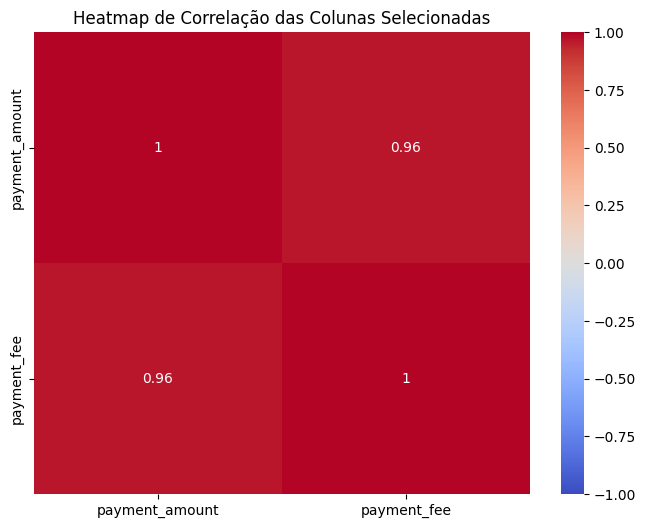

In [74]:
#Análise colunas midiáticas

colunas = ['payment_amount','payment_fee']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()

Muito correlacionado, utilizar apenas um no modelo ESCOLHER QUAL

In [75]:
df = df.drop(columns='payment_fee')

In [76]:
# Selecionando apenas as colunas numéricas do DataFrame
numeric_columns = df.select_dtypes(include=['int', 'float'])

# Exibindo as colunas numéricas
print(numeric_columns)


        order_id  order_amount  order_delivery_fee  order_delivery_cost  \
0       89066010            64                   6                  5.0   
1       74452603            74                  11                  6.0   
2       78635930            82                   9                  8.0   
3       70338727            85                   9                  8.0   
4       68874888           107                  11                  6.0   
...          ...           ...                 ...                  ...   
287453  85008042            75                   0                  9.0   
287454  86909485            26                   0                  5.0   
287456  88807164            52                   6                  0.0   
287457  88616043            23                   0                  0.0   
287458  77819085            74                   1                  8.0   

        order_created_hour  order_created_minute  order_created_day  \
0                       15  

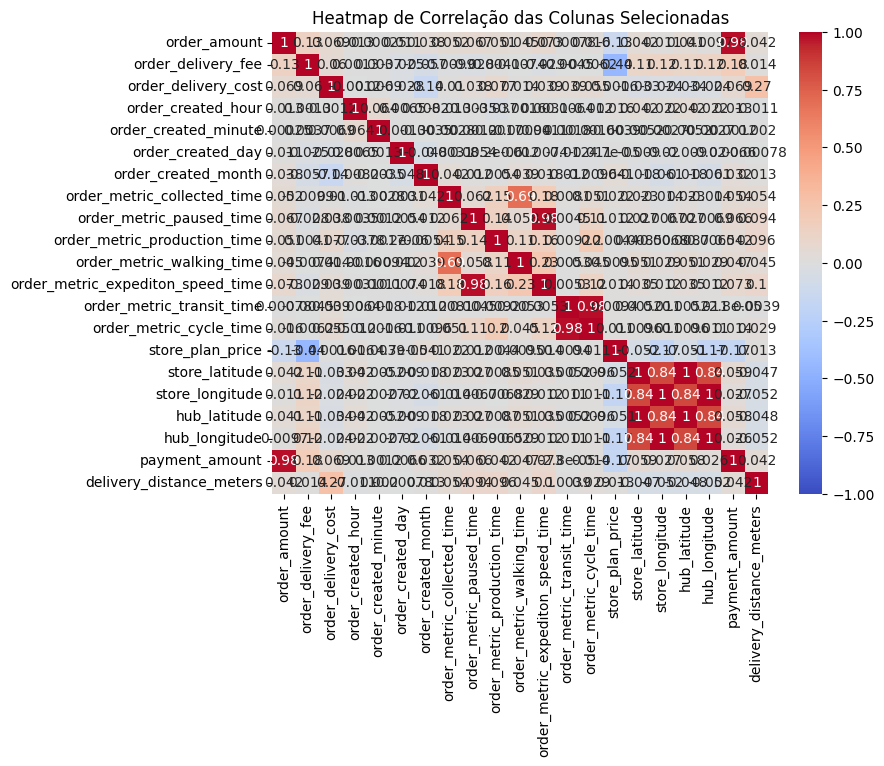

In [77]:
colunas = ['order_amount', 'order_delivery_fee', 'order_delivery_cost','order_created_hour','order_created_minute', 'order_created_day','order_created_month','order_metric_collected_time', 'order_metric_paused_time','order_metric_production_time', 'order_metric_walking_time','order_metric_expediton_speed_time', 'order_metric_transit_time','order_metric_cycle_time', 'store_plan_price','store_latitude', 'store_longitude', 'hub_latitude','hub_longitude', 'payment_amount', 'delivery_distance_meters']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()


In [78]:
def cat_var(tab, x):
  if x == 0:
    cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
  if x == 1:
    cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
  return cat

In [79]:
def preparacao(tab):
  dados = cat_var(tab, 1)
  dados = tab[dados[:-1]]
  
  order_metric_cycle_time = cat_var(tab, 1)
  order_metric_cycle_time = tab[order_metric_cycle_time[-1]]
  return dados, order_metric_cycle_time 

In [80]:
# Seleciona apenas as colunas que não são do tipo 'object'
numeric_columns = df.select_dtypes(exclude=['object'])

# Cria um novo DataFrame apenas com as colunas numéricas
new_df = df[numeric_columns.columns]

# Agora 'new_df' contém apenas as colunas que não são do tipo 'object'


In [82]:
print(new_df[new_df.isna().any(axis=1)])

        order_id  order_amount  order_delivery_fee  order_delivery_cost  \
276328  93126010            26                   0                  8.0   
276329  93126010            26                   0                  8.0   

        order_created_hour  order_created_minute  order_created_day  \
276328                  15                    18                 30   
276329                  15                    18                 30   

        order_created_month order_moment_created order_moment_finished  ...  \
276328                    4  2021-04-30 15:18:11   2021-04-30 15:57:22  ...   
276329                    4  2021-04-30 15:18:11   2021-04-30 15:57:22  ...   

        order_metric_transit_time  order_metric_cycle_time  store_plan_price  \
276328                       24.0                      NaN              49.0   
276329                       24.0                      NaN              49.0   

        store_latitude  store_longitude  hub_latitude  hub_longitude  \
276328   

In [81]:
# Suponha que df é o seu DataFrame com as colunas necessárias

# Passo 1: Divida o DataFrame em X e y
X,Y = preparacao(new_df)

# Passo 2: Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Passo 3: Importe o modelo de regressão linear
model = LinearRegression()

# Passo 4: Ajuste o modelo aos dados de treinamento
model.fit(X_train, y_train)

# Passo 5: Faça previsões usando os dados de teste
y_pred = model.predict(X_test)

# Passo 6: Calcule o MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values